# Análisis de segmentación de slientes - PYME E-commerce
## 1.Extracción y Preparación de Datos
En esta sección conectamos con la base de datos SQL local y preparamos las métricas RFM (Recency, Frequency, Monetary).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import datetime as dt

# Configuración para gráficas
plt.style.use('ggplot')
%matplotlib inline

# Conexión a la base de datos local
engine = create_engine('sqlite:///../data/proyecto_pyme.db')
df = pd.read_sql("SELECT * FROM ventas_pyme", engine)

# Conversión de tipos de datos
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

print(f"Dataset cargado. Hay {df.shape[0]} filas")
df.head()

Dataset cargado: 397924 filas


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## 2.Ingeniería de variables (métricas para RFM)
Calculamos los tres pilares del análisis **RFM**:
* **Recency:** Son los días desde la última compra
* **Frequency:** Es la cantidad total de transacciones
* **Monetary:** Es el gasto total acumulado

In [ ]:
# Fechas de referencia (1 días psoterior a la (ultima compra))
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Por cada cliente:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

# Cambiamos de nombre a las columnas
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

# Ventas reales (filtro)
rfm = rfm[rfm['Monetary'] > 0]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


## 3. Distribución de datos y outliers
Antes de aplicar clustering, analizamos la distribución en este caso mediante un Box-plot de las variables (RFM), ya que, los algoritmos basados en distancias son sensibles a valores extremos y asimetrías.

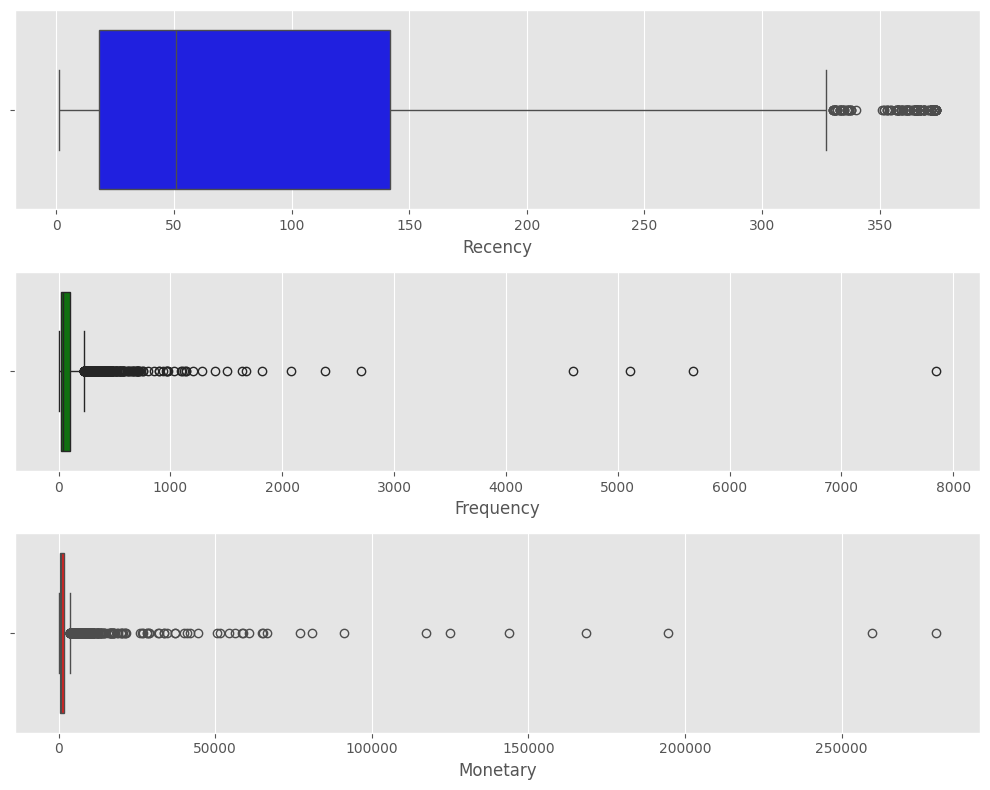

In [26]:
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1); sns.boxplot(x=rfm['Recency'], color='blue')
plt.subplot(3, 1, 2); sns.boxplot(x=rfm['Frequency'], color='green')
plt.subplot(3, 1, 3); sns.boxplot(x=rfm['Monetary'], color='red')
plt.tight_layout()
plt.savefig('../docs/distribucion.png', bbox_inches='tight', dpi=300)
plt.show()

### 4. Transformación de datos
Aplicamos logaritmo para reducir la asimetría y normalización para que tengan media 0 y desviación estándar 1.

In [4]:
from sklearn.preprocessing import StandardScaler

# Logaritmo para la asimetría
rfm_log = np.log(rfm)

# Normalización de datos
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Nuevo data frame logaritmico y normalizado
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

print("Datos listos.")
rfm_scaled.describe().round(2)

Datos listos.


,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,-0.00,0.00,-0.00
std,1.00,1.00,1.00
min,-2.63,-2.78,-4.18
25%,-0.61,-0.64,-0.68
50%,0.11,0.03,-0.06
75%,0.83,0.70,0.65
max,1.51,3.99,4.72


## 5. Clustering K-Means
Para determinar el número óptimo de clusters, utilizamos la técnica de la suma de cuadrados intra-clusters. 

Para eso verificamos en el gráfico del codo, donde se identifica el punto donde la ganancia de información empieza a ser marginal.

In [ ]:
from sklearn.cluster import KMeans

sse = {}
# Probamos de 1 a 10 clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

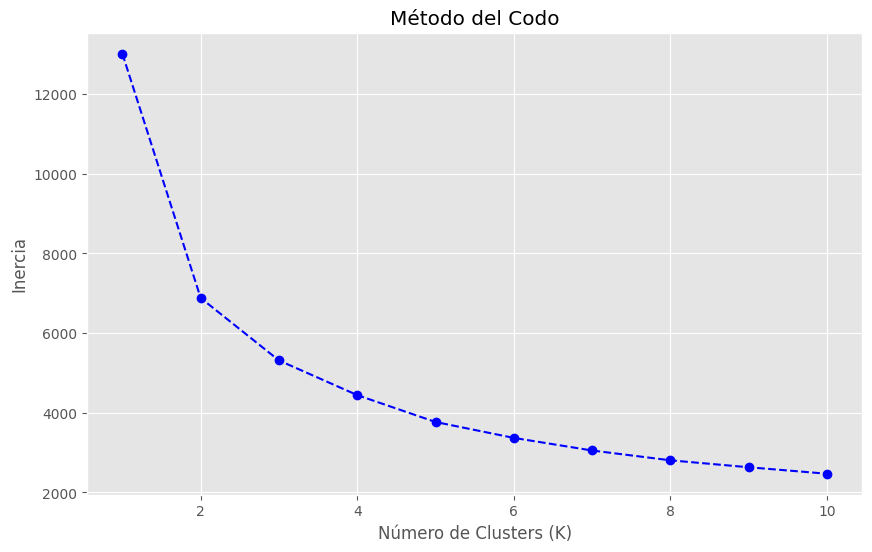

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o', linestyle='--', color='b')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.savefig('../docs/codo.png', bbox_inches='tight', dpi=300)
plt.show()

Al analizar la gráfica de inercia, se observa que a partir de K = 3, la curva comienza a aplanarse, indicando que agregar más clusters produce una mejora marginal en la reducción de la inercia. Es por esto que, se seleccionó K = 3, ya que representa el punto donde el modelo logra un buen equilibrio entre simplicidad y capacidad de agrupamiento sin sobreajustar.

### 6. Aplicación del Modelo Final
Seleccionamos K=3 basándonos en el análisis anterior.

In [21]:
# Modelo con K=3
model = KMeans(n_clusters=3, random_state=42, n_init=10)
model.fit(rfm_scaled)

# Asignar los clusters al rfm_scaled
rfm['Cluster'] = model.labels_

# Clientes por cada cluster
print("Distribución de clientes por segmento:")
print(rfm['Cluster'].value_counts())

Distribución de clientes por segmento:
Cluster
2    1854
0    1519
1     965
Name: count, dtype: int64


## 7. Interpretación
Para determinar las características de cada cluster, visualizamos los clusters.

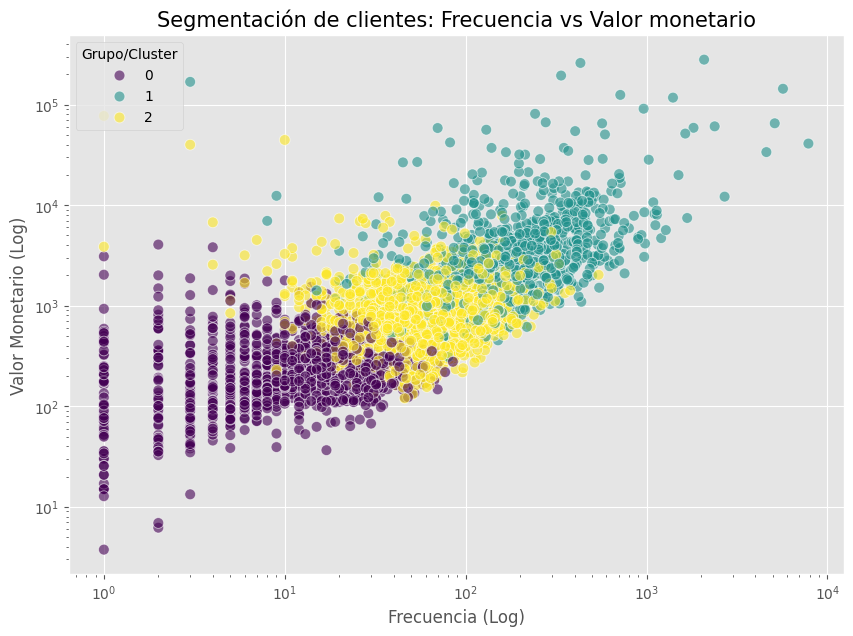

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Gráfico
plt.figure(figsize=(10, 7))

# Usamos escala logaritmica para mejor visualización
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', 
                data=rfm, palette='viridis', s=60, alpha=0.6)

plt.title('Segmentación de clientes: Frecuencia vs Valor monetario', fontsize=15)
plt.xlabel('Frecuencia (Log)', fontsize=12)
plt.ylabel('Valor Monetario (Log)', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Grupo/Cluster', loc='upper left')

# 3. Guardar
plt.savefig('../docs/clusters_scatter.png', bbox_inches='tight', dpi=300)
plt.show()

Al aplicar el algoritmo K-Means con $K=3$ sobre las métricas logarítmicas de frecuencia de compra y valor monetario, se ha identificado tres perfiles de clientes claramente diferenciados:
* Grupo 0 (Violeta) - Clientes Ocasionales o de Bajo Valor: Se ubican en la parte inferior izquierda. Tienen una frecuencia de compra baja y un gasto total reducido.
* Grupo 2 (Amarillo) - Clientes Potenciales: Situados en el centro del gráfico. Compran con una frecuencia moderada y su gasto es significativo pero estable.
* Grupo 1 (Azul) - Clientes VIP: Se encuentran en la parte superior derecha. Son los clientes más valiosos para la PYME.

## 8. Caracterización de clústers
Calculamos los promedios reales de cada métrica para asignar nombres de negocio a los clusters.

In [25]:
# Agrupamos clusters y calculamos promedios
df_perfil = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

# Renombrar para claridad
df_perfil.columns = ['Recency_Prom', 'Frequency_Prom', 'Monetary_Prom', 'Count']
df_perfil = df_perfil.sort_values(by='Monetary_Prom', ascending=False)

print("Perfil de los clusters (Promedios Reales):")
df_perfil

Perfil de los clusters (Promedios Reales):


,Recency_Prom,Frequency_Prom,Monetary_Prom,Count
Cluster,,,,
1,13.1,261.8,6523.9,965
2,69.4,66.1,1169.8,1854
0,171.3,14.9,294.2,1519


## Interpretación de la caracterización de los clusters:

* **Cluster 1 (VIP):** Es el grupo más valioso. En promedio, su última compra fue hace 13 días, lo que indica una altísima lealtad. Son clientes que compran con mucha frecuencia y gastan alrededor de $6523,9.

* **Cluster 2 (Potenciales):** Es el segmento más numeroso (1,854 clientes). Su comportamiento es moderado. En promedio, su última compra fue hace aproximadamente 2 meses. Son clientes que ya conocen la tienda pero que no compran frecuentemente, y gastan alrededor de $1169,8.

* **Cluster 0 (Ocasionales):** Son clientes que no han comprado en promedio hace 171 días (casi 6 meses). Su frecuencia y gasto son los más bajos.

## 9. Consideraciones éticas del modelo
1. **Privacidad:** Se ha ocultó el CustomerID  para proteger la identidad de los compradores.
2. **Sesgo Algorítmico:** El modelo se basa exclusivamente en comportamiento transaccional (RFM). No se han incluido variables demográficas o socioeconómicas que puedan generar discriminación.
3. **Uso Responsable:** Los resultados deben usarse para personalización de servicios y no para la exclusión de grupos vulnerables.